# Solving the Schrödinger Equation for a Quantum Well

**Objective:**  
Numerically solve the time-independent Schrödinger equation for a quantum well. Analyse bound state energies, wavefunctions, and tunnelling effects.

**Details:**

- Discretize the Schrödinger equation using the finite difference method (second-order central difference).
- Solve the resulting eigenvalue problem to obtain the energy eigenvalues and wavefunctions.
- Extend the model to a double-well potential and study tunnelling effects.
- Implement a time-dependent solution using the Crank–Nicholson method.
- Simulate a wave packet moving towards the barrier and time evolution to observe partial transmission through the barrier and reflection from the barrier.



A key principle in this project is the **Finite Difference Method**. This is a method where you approximate the differential $dx$ using a small step $\Delta x$. The time-independent Schrodinger equation is given generally by: $$ E\psi = \hat{H}\psi \ ,$$ where $$\hat{H} = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V(x) \ ,$$ is the Hamiltonian operator. In order to approximate this using the finite difference method, or the second order central difference method, the following approximation will be used: $$ \frac{d^2\psi}{dx^2} \approx \frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{\Delta x^2} \: , i = 0, 2, 3, \cdots , N \ ,$$ with $N$ being the number of divisions in the interval $[a,b]$ being looked at. This will give $N+1$ linear equations that will all need to be solved to determine the solution of the wavefunction. It is clear to see that there must be a careful balance between the number of divisions and computation time is important, and using the methods found in the Numpy module the time complexity is of $O(N^3)$.

This then gives the formula: $$\hat{H}\psi \approx -\frac{\hbar^2}{2m} \left[\frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{\Delta x^2}\right] + V(x)\psi_i = E\psi_i \ .$$ This can be written as a tridiagonal matrix of the following form, defining $\alpha = \frac{\hbar^2}{2m\Delta x^2}$:

$$
\begin{bmatrix}
2\alpha + V_0 & -\alpha & 0 & \dots & 0 \\
-\alpha & 2\alpha + V_1 & -\alpha & \dots & 0 \\
0 & -\alpha & 2\alpha + V_2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & 2\alpha + V_N
\end{bmatrix}
\cdot
\begin{bmatrix}
\psi_0 \\
\psi_1 \\
\psi_2 \\
\vdots \\
\psi_N
\end{bmatrix}= E
\begin{bmatrix}
\psi_0 \\
\psi_1 \\
\psi_2 \\
\vdots \\
\psi_N
\end{bmatrix}
$$

This is a simple eigenvalue equation and can be solved using `scipy.linalg.solve_banded()` which will take the tridiagonal matrix and the column vector of wavefunctions at each step and return the corresponding energy of the wavefunction.



In [3]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal, solve_banded
from sympy.physics.hydrogen import R_nl, E_nl
from sympy import symbols, lambdify
from scipy.integrate import simps
from scipy.sparse import diags
from scipy.optimize import curve_fit
import matplotlib.animation as animation
from IPython.display import HTML

import PotentialsNew as p
importlib.reload(p)
import HMatNew as H
importlib.reload(H)

<module 'HMatNew' from '/home/user/HMatNew.py'>

In [4]:
# These constants will be used to convert from natural units where h=m=c=e=1 to the appropriate units, such as J or eV
h_conv = 6.63e-34 # Js
hbar_conv = h_conv/(2*np.pi) # Js
c_conv = 299792458 # m/s
e_conv = 1.60e-19 # C
mass_elec = 9.11e-31 # kg
eps0_conv = 8.85e-12 # F/m

# Setting the bounds and deltaX
lower = -5 # Lowest x value
upper = 5 # Largest x value
N = 5000 # The number of points on the x axis
x = np.linspace(lower, upper, N) # The x axis split into N points
deltaX = (x[1] - x[0]) # Finds the separation between the two points

v0 = 15 # The height of the potential barrier used for the animation
L = 1 # The width of the potential barrier used for the animation

# Defining conversion factors
distance_conv = 1e-9 # m to nm
h = 1
hbar = 1
c = 1
e = 1
mass = 1

# Define Gaussian wave packet parameters
x0 = 0 # m, original position
sigma = 1  # Width of the packet

v_g = 5  # Picked arbitrarily
k0 = mass * v_g / hbar  # Compute corresponding wave number, kinda irrelevant when hbar and mass = 1
p0 = hbar * k0  # Compute momentum, again kinda irrelevant when hbar = 1

energyConversion = hbar_conv**2 / (mass_elec * distance_conv**2)

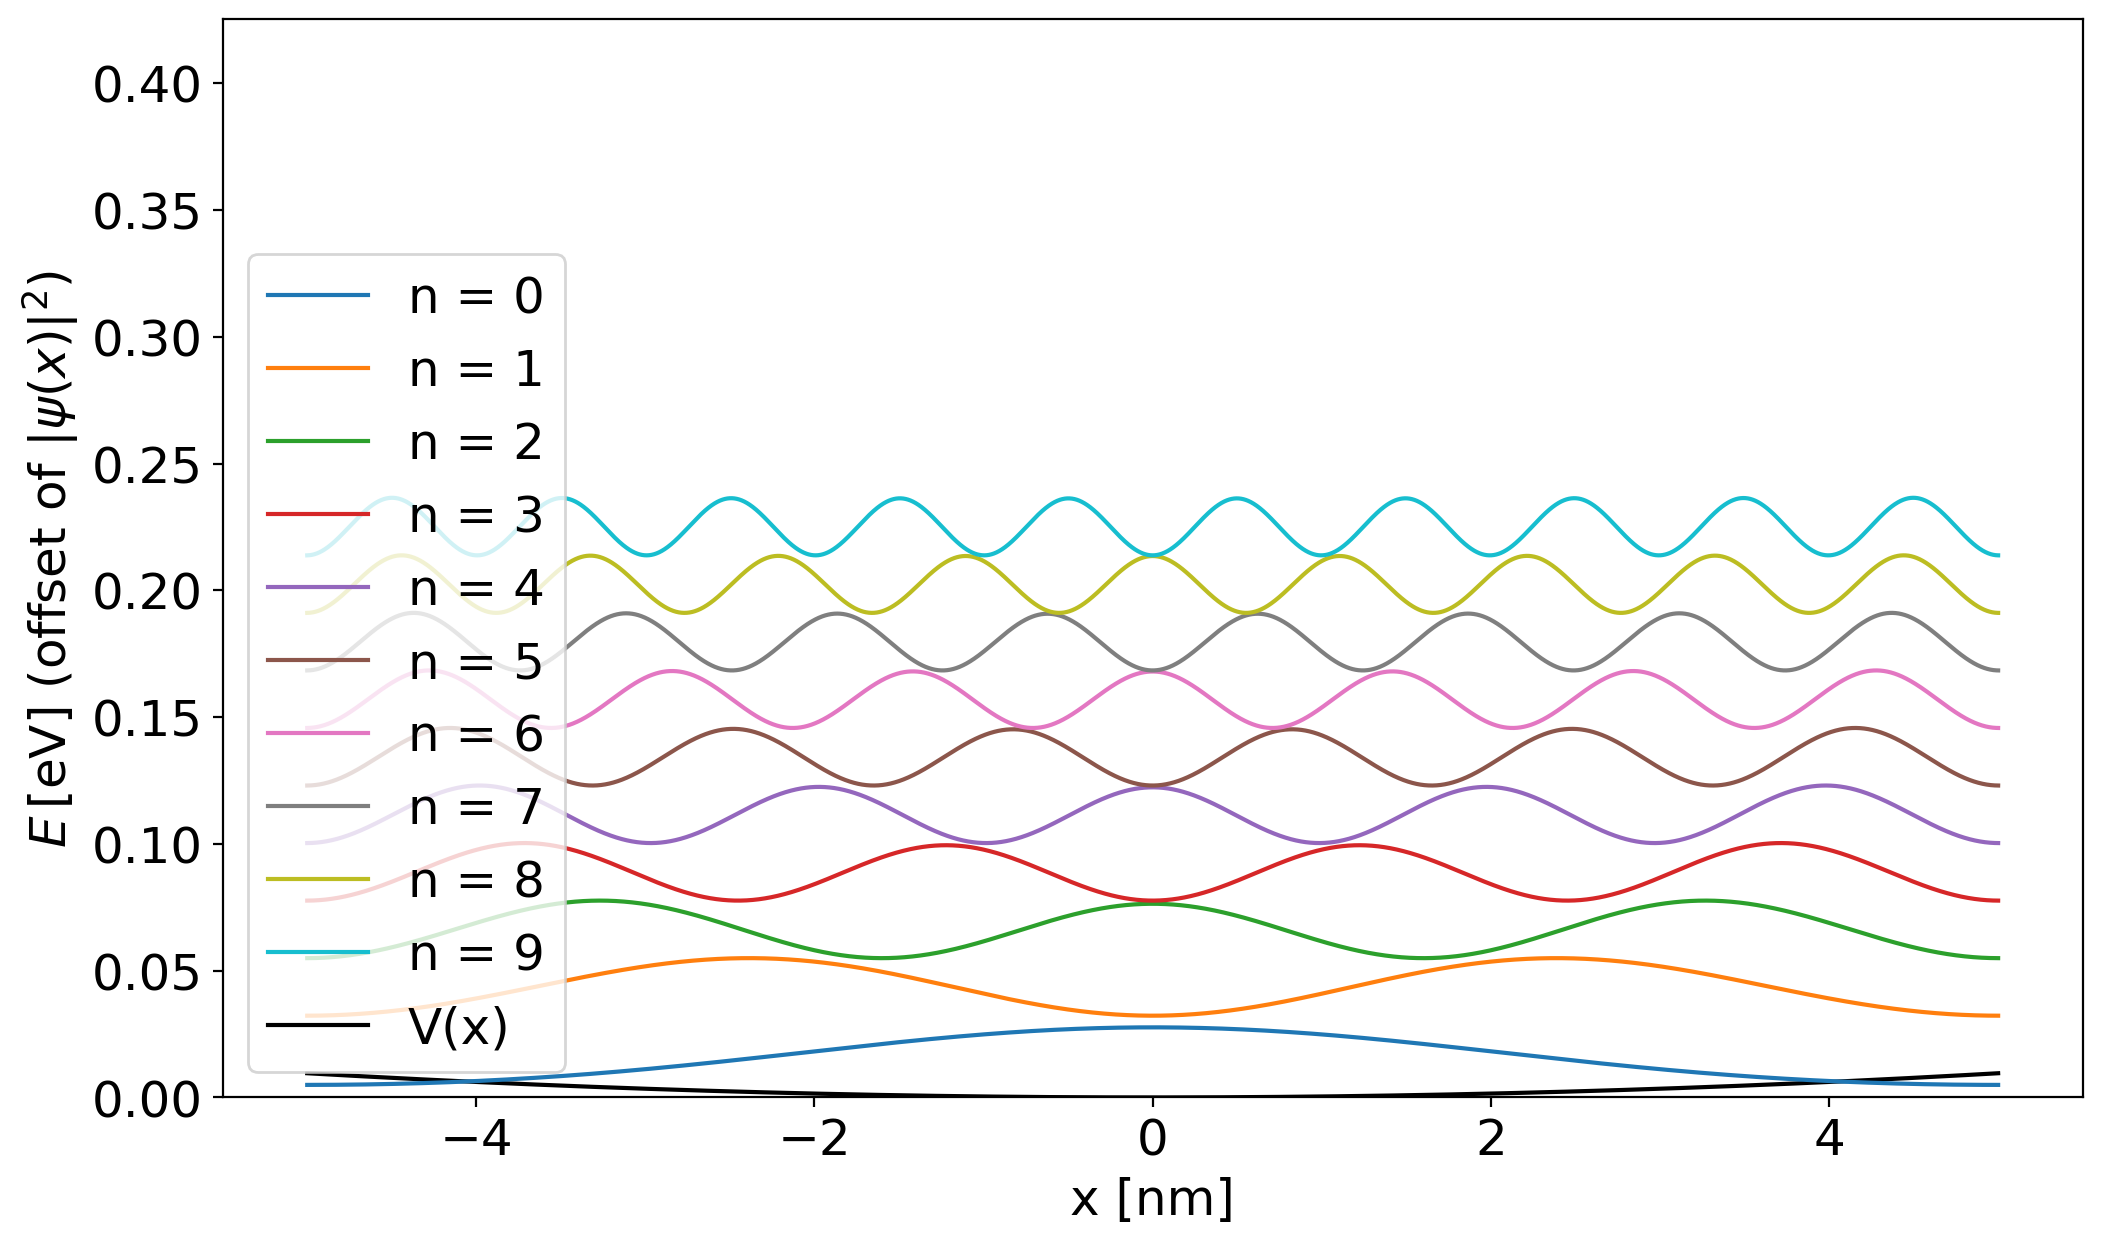

In [4]:
# A dictionary containing some example potentials that can be swapped between
examplePotentials = {"FreeParticle":p.FreeParticle(mass=1, momentum=5), 
                     "HarmonicOscillator":p.HarmonicOscillator(mass=1, width=2.5, omega=0.1, center=0),
                     "FinitePotentialWell":p.FinitePotentialWell(mass=1, width=5, xmin=-2.5, v0=3),
                     "InfinitePotentialWell":p.InfinitePotentialWell(mass=1, width=5, xmin=-2.5),
                     "PotentialBarrier":p.PotentialBarrier(mass=1, width=1, xmin=-0.5, v0=15), 
                     "DoublePotentialWell":p.DoublePotentialWell(mass=1, width=0.5, xmin1= 0.5, xmin2=2, v0=25),
                     "DoubleSmoothPotential":p.DoubleSmoothPotential(mass=1)
                    }

potentialType = "HarmonicOscillator" # Specifying the potential type

potential = examplePotentials[potentialType]

A = H.Hamiltonian(potential, x) # Create the Hamiltonian object
eigenvalues, eigenvectors = A.solve()
# Solve to generate the eigenvalues and eigenvectors, the eigenvalues need to have their dimensions adjusted so that they represent energies rather than being dimensionless

fig, ax1 = plt.subplots()
ax1.set_xlabel('x [nm]', fontsize=18)
ax1.set_ylabel(r"$E\,[\mathrm{eV}]$ (offset of $|\psi(x)|^2$)", fontsize=18)

maxWavefunc = 10
scaling = (eigenvalues[maxWavefunc] - eigenvalues[0]) * 0.05  # 5% of energy range

for i in range(maxWavefunc):
    prob_density = eigenvectors[:, i]**2
    prob_density /= prob_density.max()  # normalise to 1
    # Shift based on eigenvalue
    if eigenvalues[i] <= max(A.V):
        shifted_wavefunction = prob_density * scaling + eigenvalues[i]
    else:
        # Add an extra small offset if above potential
        shifted_wavefunction = prob_density * scaling + max(A.V) + (i * scaling)
    ax1.plot(x, shifted_wavefunction * energyConversion/e_conv, label=f'n = {i}')
                 
# Plot potential on same axis
ax1.plot(x, A.V * energyConversion/e_conv, color='black', label='V(x)', zorder=0)

# Add legend, remove y-ticks
ax1.legend(loc=3, fontsize = 18)
#ax1.set_yticks([])

ax1.set_ylim(0, (eigenvalues[maxWavefunc-1] + scaling*2)*energyConversion/e_conv)
ax1.tick_params(labelsize=18)
#plt.savefig(potentialType)
plt.show()

In [5]:
# Checking waves are orthonormal
NStates = 15
total = []
for i in range(NStates):
    for j in range(NStates):
        if i != j:
            overlap = simps(np.conj(eigenvectors[:, i] * eigenvectors[:, j]), x)
            total.append(overlap)
mean = np.mean(total)
err = np.std(total, ddof = 1) / np.sqrt(NStates)

print(f"({mean*1e12} +- {err*1e12})e-12")

(0.7398277593517762 +- 2.868696585481556)e-12


The next step is to move onto the time **dependant** Schrodinger equation (TDSE) . The method used to solve this will be the Crank-Nicholson method. The time dependant Schrodinger equation is given by: $$i\hbar \frac{\partial \psi}{\partial t} = \hat{H}\psi = -\frac{\hbar^2}{2m} \frac{\partial^2\psi}{\partial x^2} + V(x,t)\psi \ .$$ Using the Crank-Nicholson method this can be rewritten in the form: $$(I - \frac{i\Delta t}{2\hbar}\hat{H})\psi^{(n)} = (I + \frac{i\Delta t}{2\hbar}\hat{H})\psi^{(n-1)} \ ,$$ with $\hat{H}$ being the Hamiltonian obtained from the TISE. Writing this as a matrix equation we obtain: $$M_1\psi^{(n)} = M_2 \psi^{(n-1)} \ ,$$ meaning that the next wavefunction is obtained from the previous one by inverting $M_1$ to get $M_1^{-1}$ giving a final equation of the form: $$\psi^{(n)} = M_1^{-1} M_2 \psi^{(n-1)} \ .$$ This would be the best way to solve this if it was done by hand, but seeing as we can make use of `scipy.linalg.solve_banded()` we can just solve the general equation $Ax = b$.

In [6]:
# Redefine the potential for a new potential
potential = examplePotentials["FreeParticle"]

A = H.Hamiltonian(potential, x) # Create the Hamiltonian object
eigenvalues, eigenvectors = A.solve()

# Define incoming Gaussian wave packet and normalise it
wavefunc = np.exp(-((x - x0) ** 2) / (2 * sigma ** 2)) * np.exp(-1j * k0 * x)
wavefunc /= np.linalg.norm(wavefunc) * np.sqrt(deltaX)  # Normalise only at start

# Identity matrix
I = np.identity(N)

# Build the Hamiltonian matrix (dense array) from its tridiagonal pieces
H_mat = diags([A.lowerDiag, A.mainDiag, A.upperDiag], offsets=[-1, 0, 1]).toarray()

# Time step, we want a 15 second video that covers a simulated time of 2s, these can be adjusted along with the group velocity above to change how fast the particles move
fps = 30 # s^-1
duration = 15 # s
simulationTime = 2 #s

deltaT = simulationTime / (fps * duration)

# Define M1 and M2
M1 = I - (1j * deltaT) / (2 * hbar) * H_mat
M2 = I + (1j * deltaT) / (2 * hbar) * H_mat

# Extract the banded diagonals from M1 (for solve_banded)
lowerDiag_M1 = np.diag(M1, k=-1)  # subdiagonal
mainDiag_M1  = np.diag(M1, k=0)   # main diagonal
upperDiag_M1 = np.diag(M1, k=1)   # superdiagonal

# Correct the banded matrix format
M1_banded = np.vstack([
    np.append(upperDiag_M1, [0]),  # Superdiagonal padded at the end
    mainDiag_M1,                    # Main diagonal
    np.append([0], lowerDiag_M1)    # Subdiagonal padded at the beginning
])

# Generate an array to store the history of the wavefunction
wavefuncHistory = [wavefunc]

# Loop through the required number of timesteps 
timesteps = fps*duration
for _ in range(timesteps):
    rhs = M2 @ wavefunc # Determine the rhs of the equation
    wavefunc = solve_banded((1, 1), M1_banded, rhs)  # Solve the equation Ax=b, updating the next wavefunction using the previous
    wavefuncHistory.append(wavefunc) # Append the current wavefunction to wavefuncHistory array

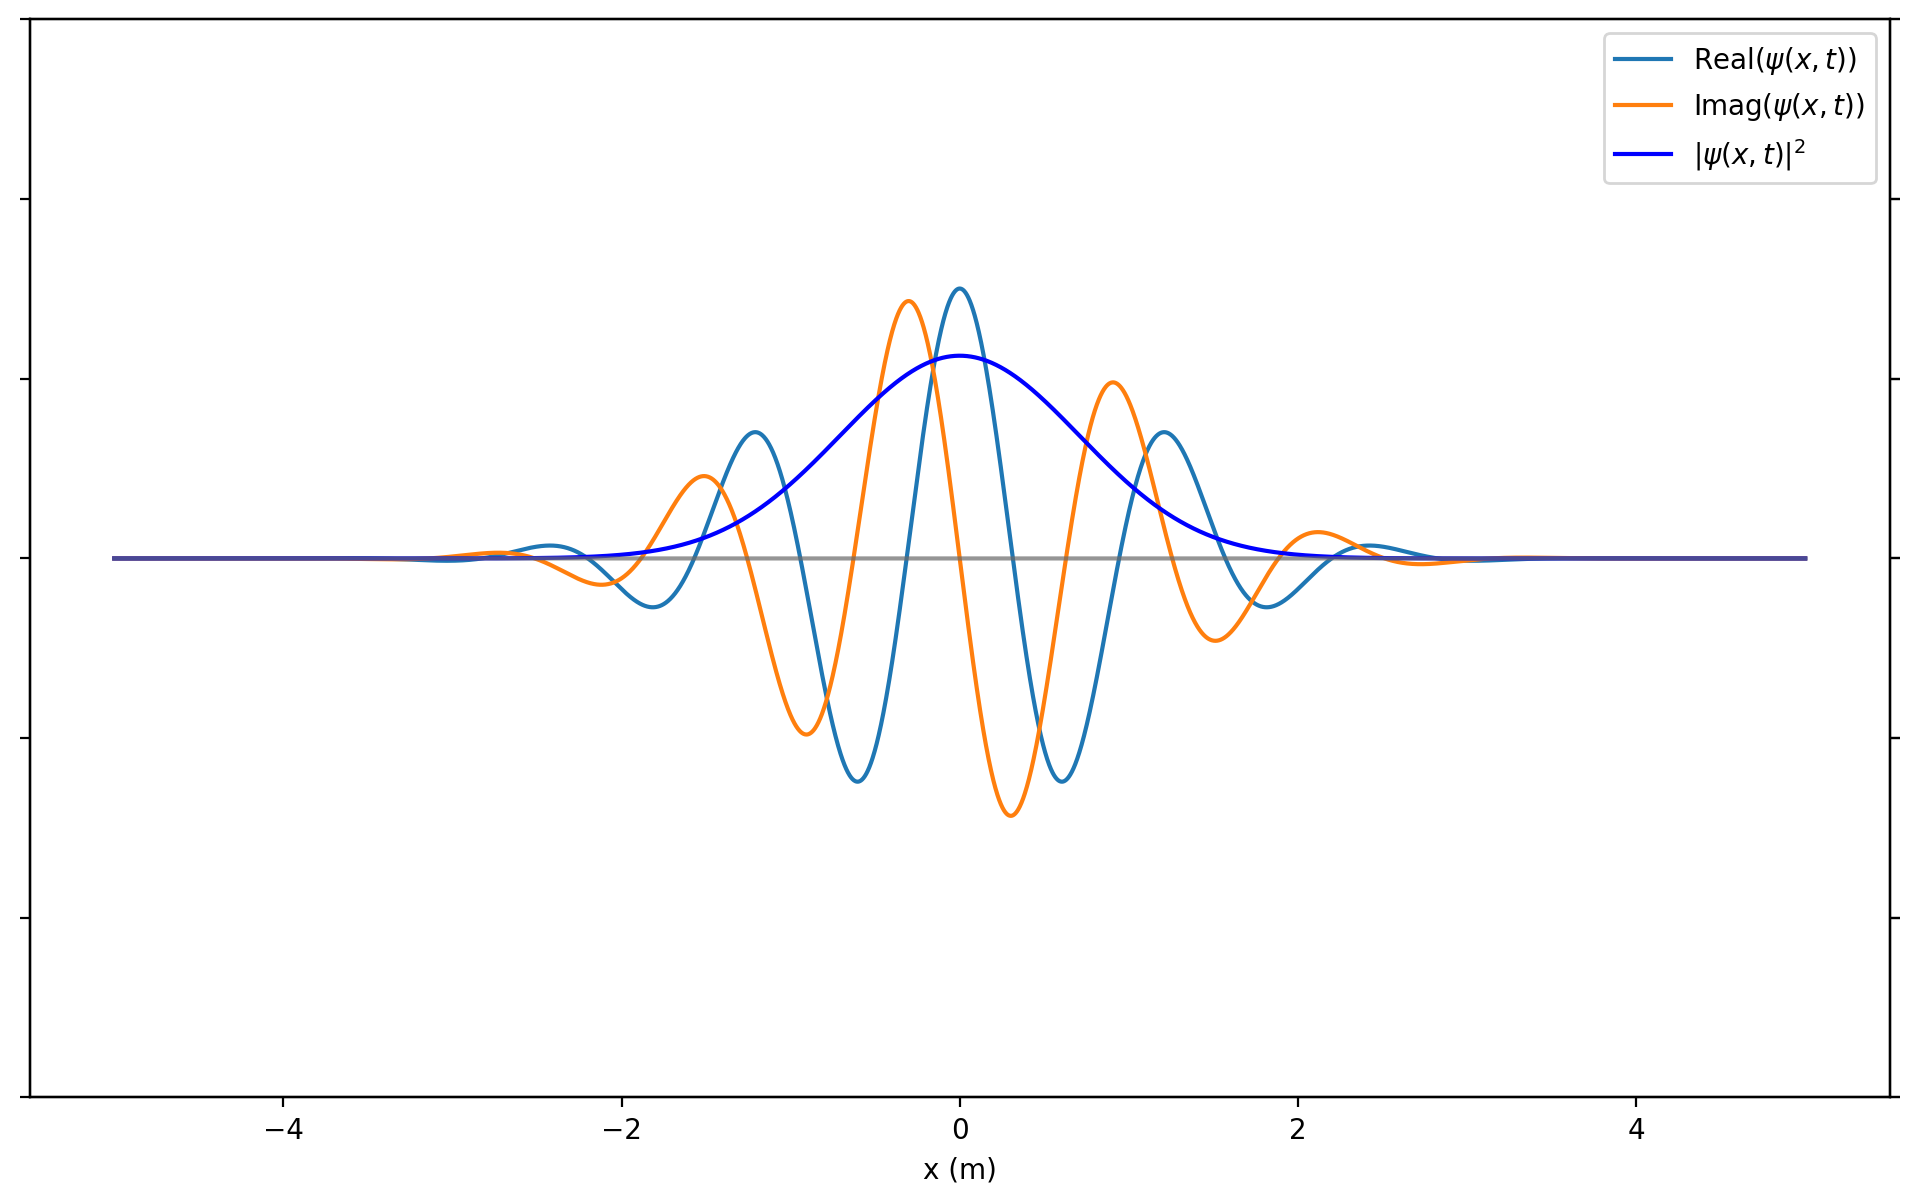

In [7]:
# Generate the subplots to allow all waves to be plotted on the same axis and fit within the same scale
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# Plot real & imaginary on ax1
real_line, = ax1.plot(x, wavefuncHistory[0].real, label=r'Real($\psi(x,t)$)')
imag_line, = ax1.plot(x, wavefuncHistory[0].imag, label=r'Imag($\psi(x,t)$)')

# Plot probability density on ax2
prob_line, = ax2.plot(x, np.abs(wavefuncHistory[0])**2, label='$|\psi(x,t)|^2$', color = 'blue')

# Plot the potential on ax3
potential_line = ax3.plot(x, A.V if max(A.V) != 0 else A.V, color = 'dimgray', alpha = 0.7)

# Set the x label to be m
ax1.set_xlabel('x (m)')

# Align the zero points
ax1.set_ylim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax3.set_ylim(-1.5, 1.5)

# Remove y-axis labels and ticks
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

# Combine legends for both y-axes
lines = [real_line, imag_line, prob_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

# Carry out the animation
def update(frame):
    psi = wavefuncHistory[frame]
    real_line.set_ydata(psi.real)
    imag_line.set_ydata(psi.imag)
    prob_line.set_ydata(np.abs(psi)**2)
    return real_line, imag_line, prob_line

ani = animation.FuncAnimation(
    fig, update, frames=len(wavefuncHistory), 
    interval=1000/fps, blit=False
)

# Display the animation
HTML(ani.to_html5_video())


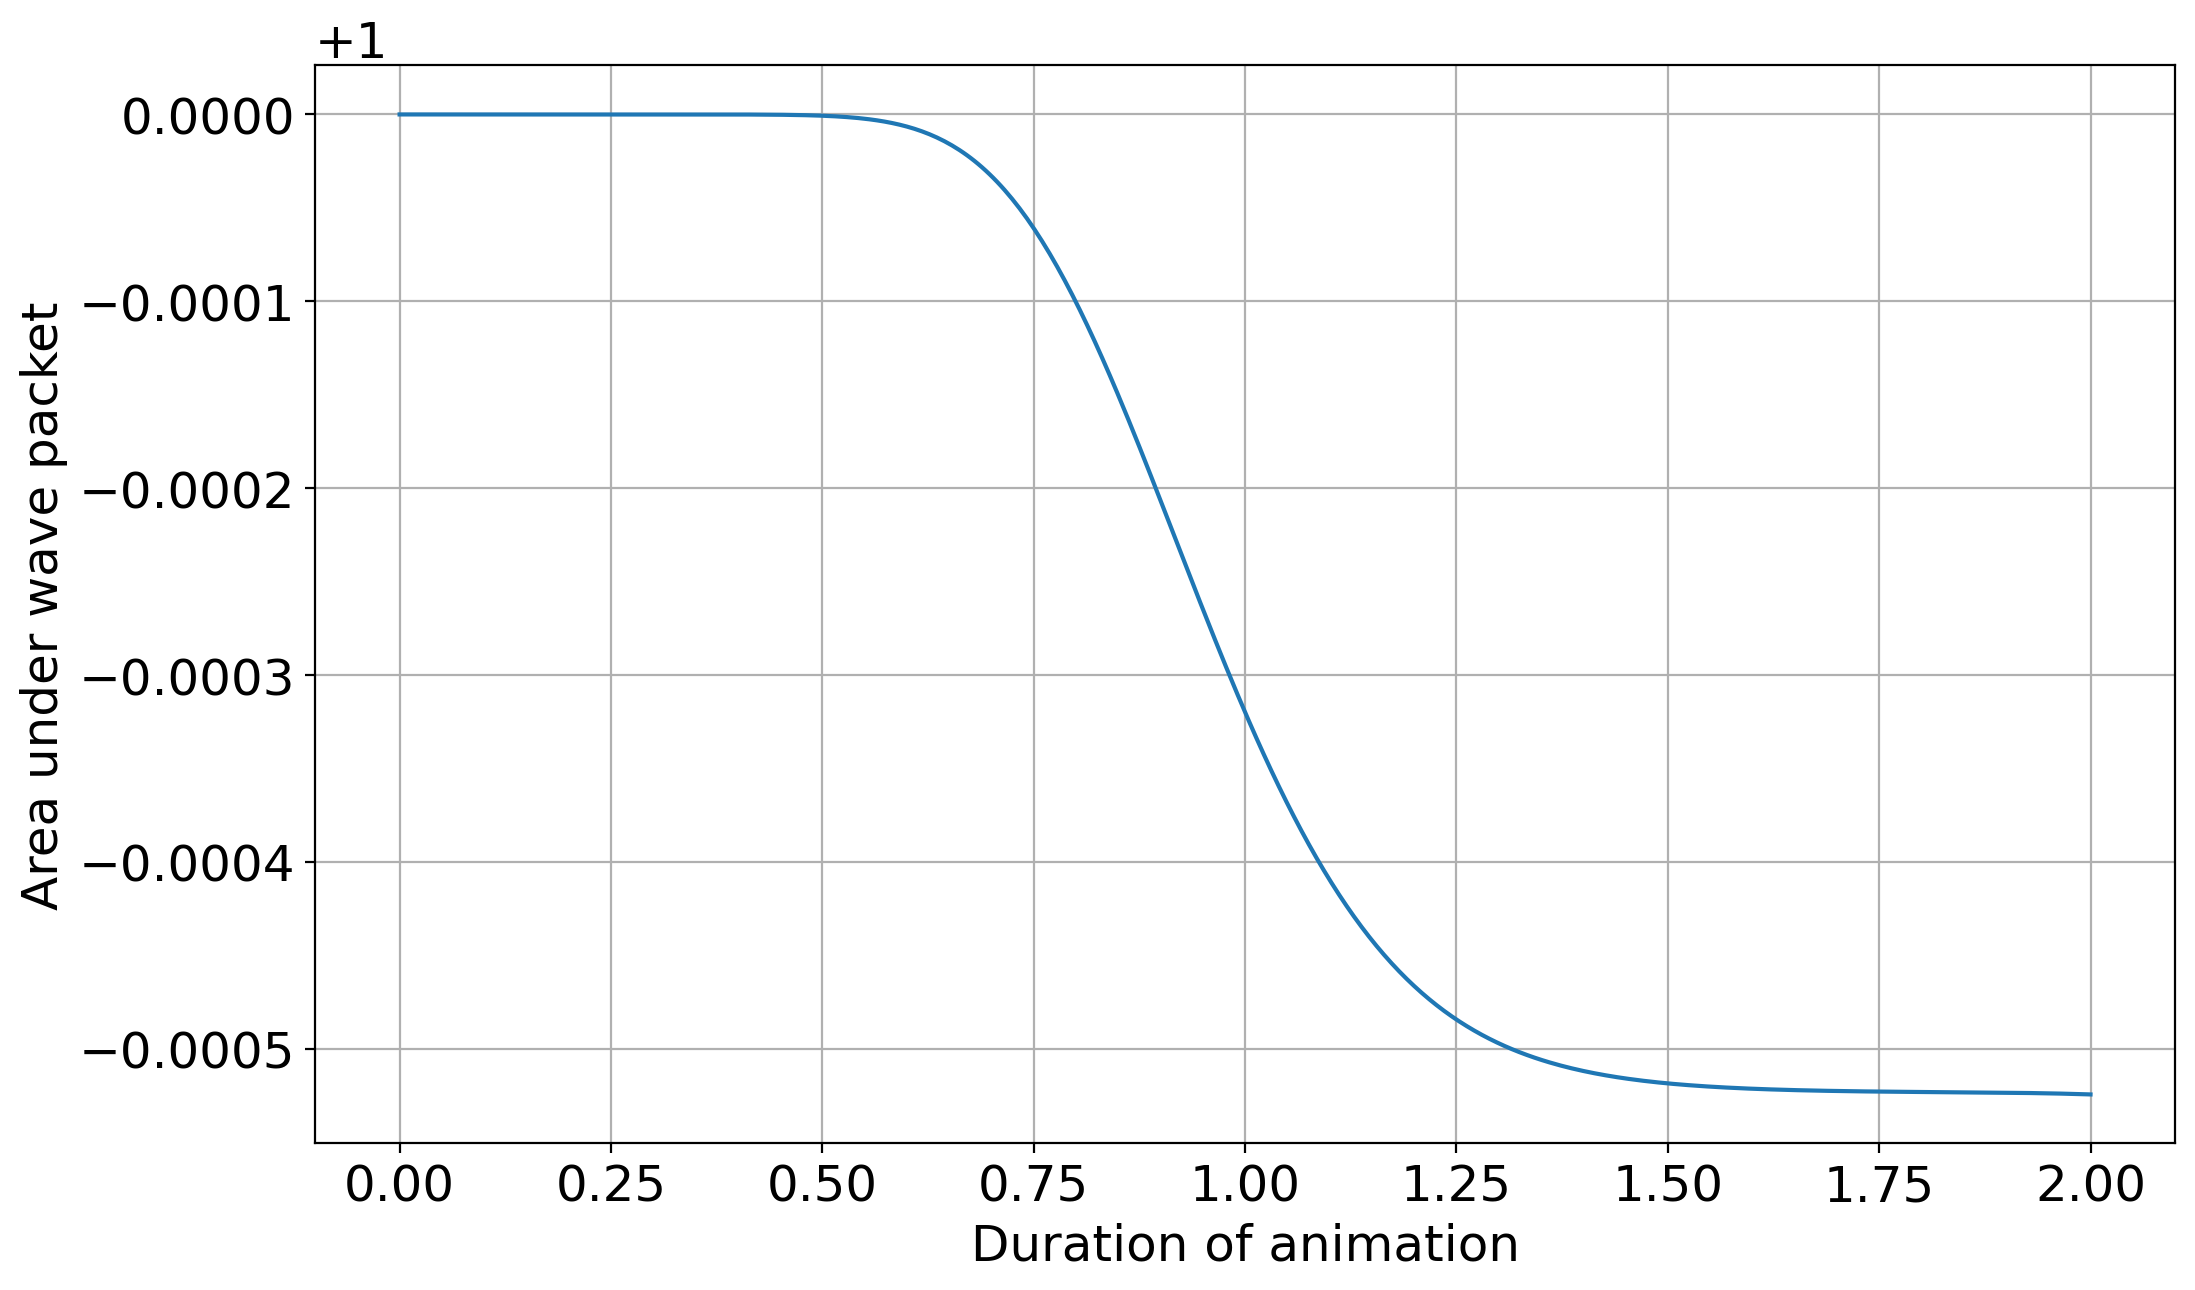

In [9]:
areaArr = []
for wavefunc in wavefuncHistory:
    probDens = np.abs(wavefunc)**2
    currArea = simps(probDens, x)
    areaArr.append(currArea)

wavefuncNum = np.arange(0, simulationTime+deltaT, deltaT)

plt.plot(wavefuncNum, areaArr)
plt.ylabel('Area under wave packet', fontsize=18)
plt.xlabel('Duration of animation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.gca().yaxis.get_offset_text().set_fontsize(18)
plt.show()

The final step will be to determine the incident, $(I)$, reflection $(R)$, barrier, and transmission $(T)$ coefficients for a potential barrier. We define the coefficients as follows: $$ I = \int_{-\infty}^{\infty} |\psi(x, t_0)|^2 \, dx  \ ,$$ $$ R = \int_{-\infty}^{x_0} |\psi(x, t_f)|^2 \, dx  \ ,$$ $$ T = \int_{x_0 + \Delta x_0}^{\infty} |\psi(x, t_f)|^2 \, dx  \ ,$$ $$ B = \int^{x_0 + \Delta x_0}_{x_0} |\psi(x, t_f)|^2 \, dx  \ ,$$ with $x_0$ representing the position of the barrier and $\Delta x$ representing the width of the barrier. This can be solved pretty simply using our earlier analysis.We expect that $I = T + R + B$.

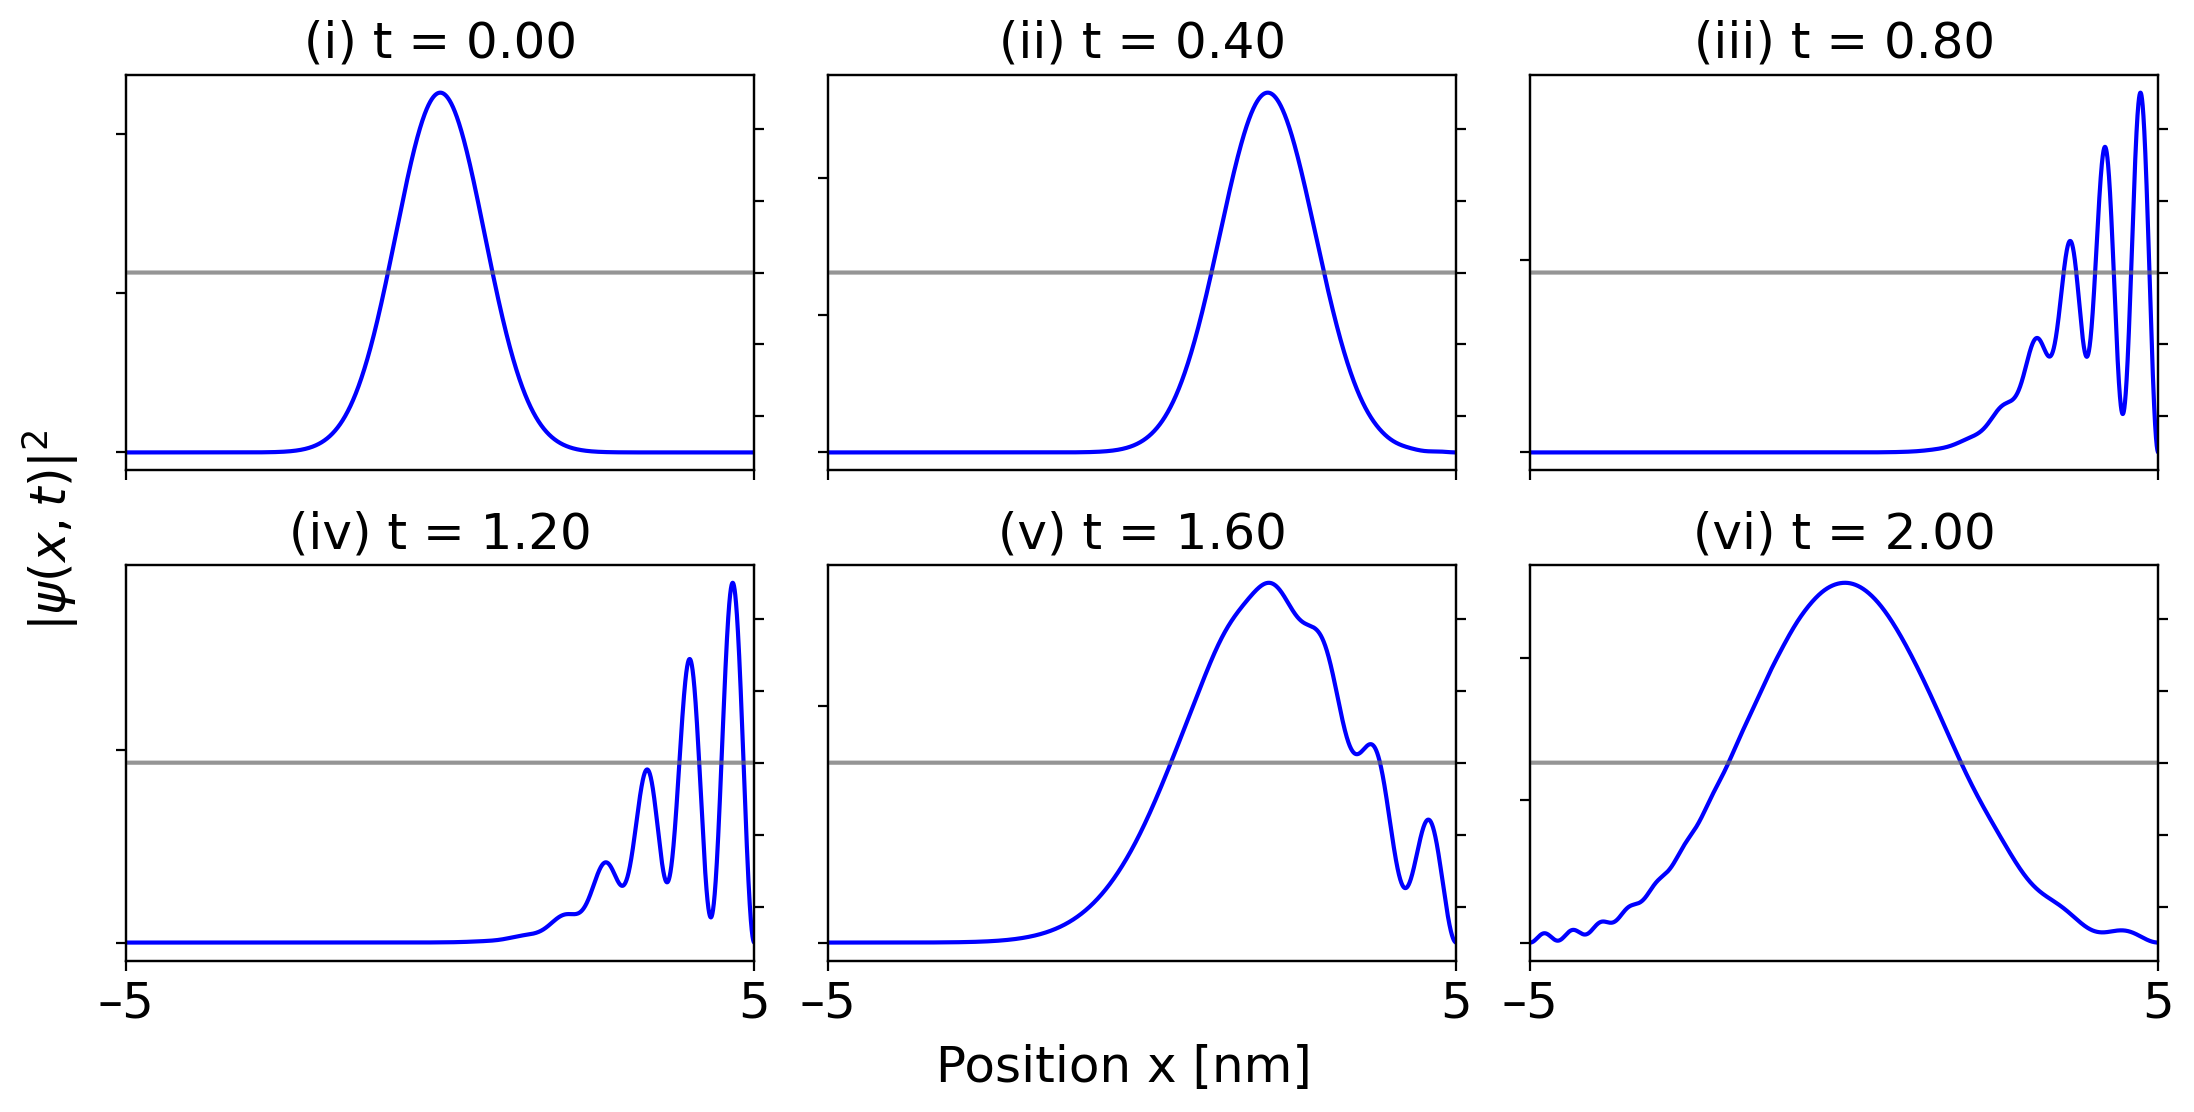

In [12]:
# Plot several time steps
roman_numerals = ['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
tsteps = np.array([0, 90, 180, 270, 360, 450])
frametimes=tsteps*deltaT
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex = True)
axes = axes.flatten()

for i, t in enumerate(tsteps):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    ax1.plot(x, np.abs(wavefuncHistory[t])**2, color='blue')
    ax2.plot(x, A.V, color='dimgray', alpha=0.7)
    
    ax1.set_yticklabels([])
    ax1.set_xticks([-5, 5])
    ax1.set_xticklabels(['–5', '5'])
    
    ax2.set_yticklabels([])

    ax1.set_title(f'{roman_numerals[i]} t = {frametimes[i]:.2f}', fontsize=18)
    ax1.set_xlim(x.min(), x.max())
    ax1.tick_params(labelsize=18)
    
fig.text(0.5, 0.04, 'Position x [nm]', ha='center', fontsize=18)
fig.text(0.04, 0.5, r'$|\psi(x, t)|^2$', va='center', rotation='vertical', fontsize=18)
plt.tight_layout(rect=[0.06, 0.06, 0.95, 0.95])
plt.show()    

In [0]:
# Calculate coefficients
potential = p.PotentialBarrier(mass=1, width=1, xmin=-0.5, v0=15)
A = H.Hamiltonian(potential, x) # Create the Hamiltonian object
eigenvalues, eigenvectors = A.solve()

wavefuncHistory = np.array(wavefuncHistory)

x_I = x[x < potential.xmin]                               # Incident region
x_T = x[x > potential.xmin + potential.width]             # Transmitted region
x_R = x[x < potential.xmin]                               # Reflected region (same as x_I)
x_B = x[(x > potential.xmin) & (x < potential.xmin + potential.width)]

# Get corresponding wavefunction slices
psi_I = np.abs(wavefuncHistory[0, x < potential.xmin])**2


    
R_arr = []
T_arr = []
B_arr = []
for i in range(len(wavefuncHistory)):
    psi_T = np.abs(wavefuncHistory[i, x > potential.xmin + potential.width])**2
        psi_R = np.abs(wavefuncHistory[i, x < potential.xmin])**2
        psi_B = np.abs(wavefuncHistory[i, (x > potential.xmin) & (x < potential.xmin + potential.width)])**2

        # Integrate probability densities
        R = simps(psi_R, x_I)
    )
        T = simps(psi_T, x_T)
        B = simps(psi_B, x_B)
    
    _arr.append(R)
    T_arr.append(T)
    B_arr.append(B)

R_arr = np.array(R_arr)
T_arr = np.array(T_arr)
B_arr = np.array(B_arr)

    
x_coeff = np.arange(0, len(wavefuncHistory))
plt.plot(x_coeff, R_arr, label = 'Incident/Reflected')
plt.plot(x_coeff, T_arr, label = 'Transmitted')
plt.plot(x_coeff, B_arr, label = 'Inside the barrier')
plt.plot(x_coeff, R_arr + T_arr + B_arr, label = 'Sum')
plt.legend()
plt.show()

print("The final coefficients are:")
print(f"I/R = {R_arr[-1]:.3f}")
print(f"T = {T_arr[-1]:.3f}")
print(f"B = {B_arr[-1]:.3f}")import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 3, figure=fig)

axes = []
# Top row: all 3 columns
for i in range(3):
    axes.append(fig.add_subplot(gs[0, i]))

# Bottom row: centre the two by skipping column 0
axes.append(fig.add_subplot(gs[1, 1]))
axes.append(fig.add_subplot(gs[1, 2])for t in tsteps:
    ax1.set_title(f't = {t}')
    ax1.set_xlim(x.min(), x.max())

plot(x, np.abs(wavefuncHistory[t])**2, color='blue')
    ax1.set_xlabel('x [m]')

    ax1.legend()
ax2.plot(x, coefficientsH.V)
print(len(wavefuncHistory))

In [0]:
print(p.DoublePotentialWell)  # Confirm the class exists
width = 0.5
potential = p.DoublePotentialWell(mass=1, width= width, xmin1= 0.5, xmin2=2, v0=25)
print("Object attributes:", vars(potential))  # Show all attributes


Key Results:
Maximum transmission: 0.909 at √(V₀-Eₖ) = 0.71
Minimum reflection: 0.059 at √(V₀-Eₖ) = 0.71


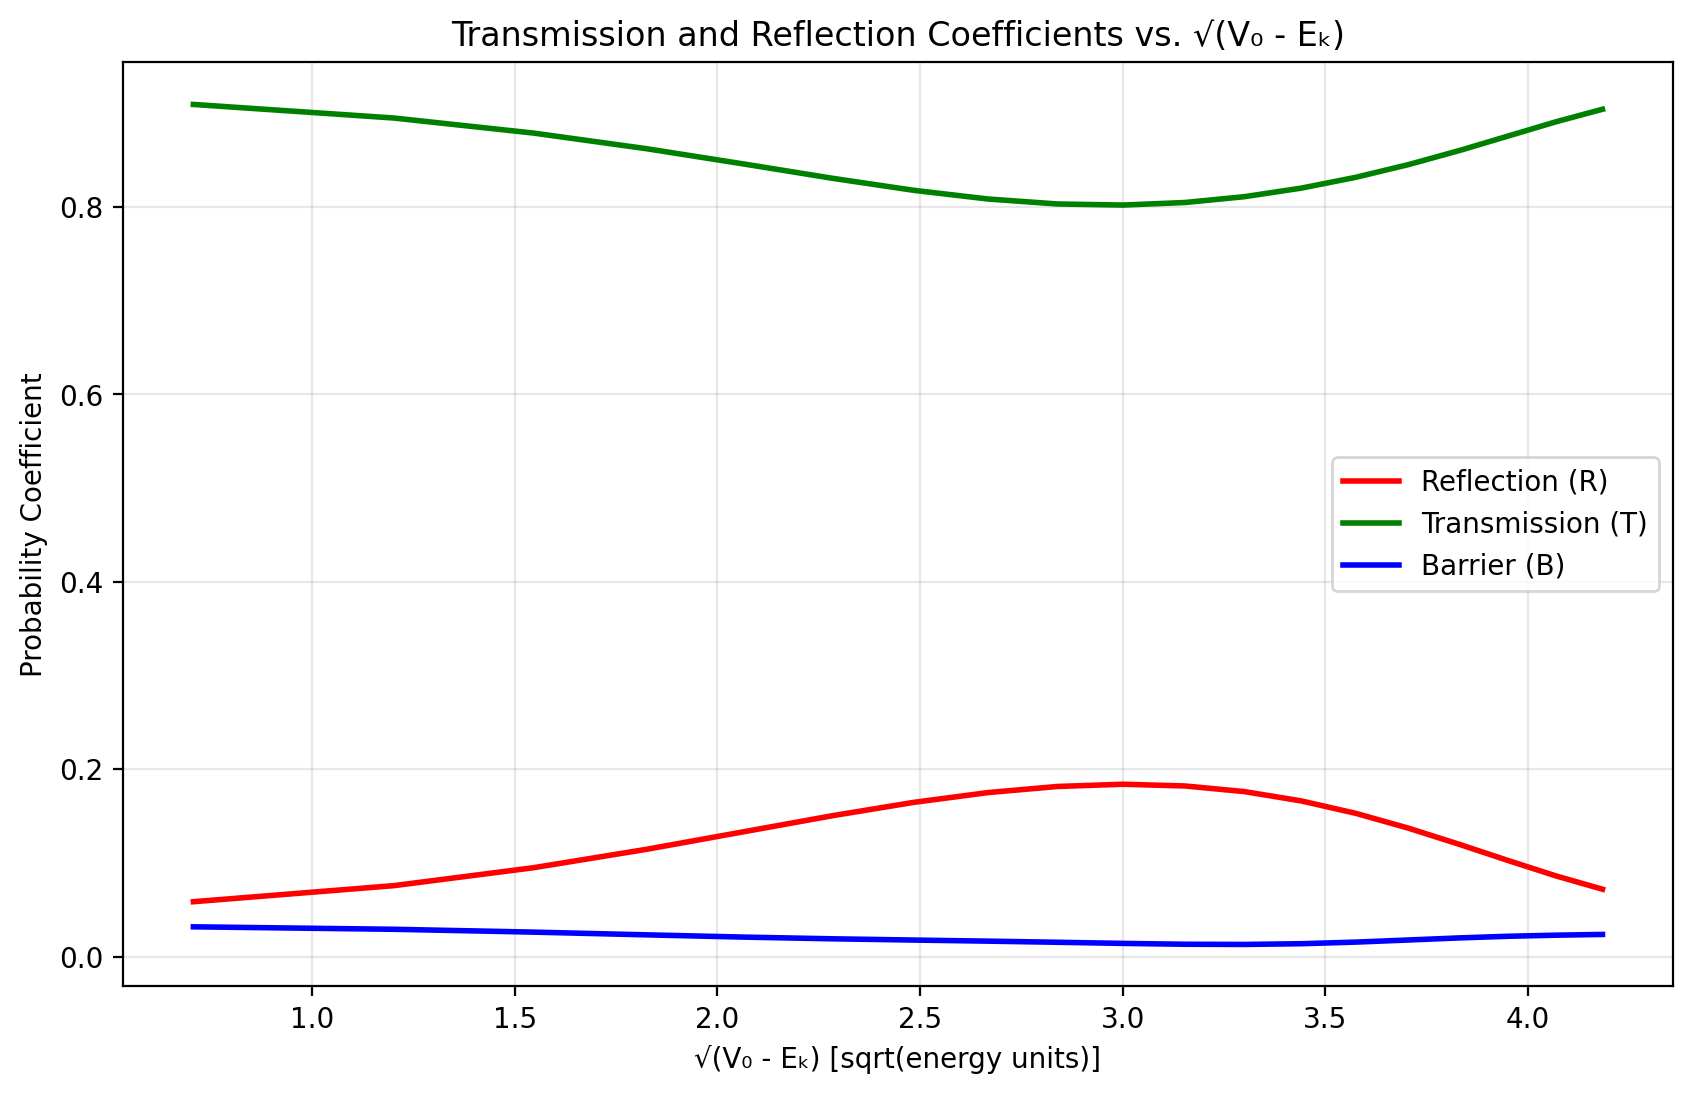

In [41]:
# Define barrier height range (more points for smoother curves)
v0_values = np.linspace(13, 30, 19)  # Barrier heights to test

# Dictionary to store coefficients
coefficients = {'R': [], 'T': [], 'B': []}
sqrt_v0_minus_Ek = []  # Will store sqrt(V0 - Ek) values

# Fixed parameters
v_g = 5  # Fixed group velocity
k0 = mass * v_g / hbar  # Wave number
p0 = hbar * k0  # Momentum
Ek =12.5  # Particle kinetic energy

for v0 in v0_values:
    # Calculate sqrt(V0 - Ek) for x-axis
    sqrt_val = np.sqrt(v0 - Ek)
    sqrt_v0_minus_Ek.append(sqrt_val)
    
    # Define potential barrier (fixed width, varying height)
    potential = p.FinitePotentialWell(mass=1, width=1, xmin=-2.5, v0=v0)
    
    # Create Hamiltonian object and solve for eigenvalues/eigenvectors
    A = H.Hamiltonian(potential, x)
    eigenvalues, eigenvectors = A.solve()

    # Define and normalize the initial Gaussian wave packet
    wavefunc = np.exp(-((x - x0) ** 2) / (2 * sigma ** 2)) * np.exp(-1j * k0 * x)
    wavefunc /= np.linalg.norm(wavefunc) * np.sqrt(deltaX)

    # Identity matrix
    I = np.identity(N)

    # Build Hamiltonian matrix
    H_mat = diags([A.lowerDiag, A.mainDiag, A.upperDiag], offsets=[-1, 0, 1]).toarray()

    # Define time step parameters
    fps = 30  # Frames per second
    duration = 15  # seconds
    simulationTime = 1  # seconds
    deltaT = simulationTime / (fps * duration)

    # Define M1 and M2 matrices
    M1 = I - (1j * deltaT) / (2 * hbar) * H_mat
    M2 = I + (1j * deltaT) / (2 * hbar) * H_mat

    # Extract banded diagonals for efficient solving
    lowerDiag_M1 = np.diag(M1, k=-1)  # subdiagonal
    mainDiag_M1 = np.diag(M1, k=0)    # main diagonal
    upperDiag_M1 = np.diag(M1, k=1)    # superdiagonal

    M1_banded = np.vstack([
        np.append(upperDiag_M1, [0]),  # Superdiagonal padded at the end
        mainDiag_M1,                   # Main diagonal
        np.append([0], lowerDiag_M1)    # Subdiagonal padded at the beginning
    ])

    # Time evolution loop
    wavefunc_history = [wavefunc]
    timesteps = fps * duration
    for _ in range(timesteps):
        rhs = M2 @ wavefunc_history[-1]  # Compute right-hand side
        wavefunc = solve_banded((1, 1), M1_banded, rhs)  # Solve Ax = b
        wavefunc_history.append(wavefunc)

    # Convert to array for easier slicing
    wavefunc_history = np.array(wavefunc_history)

    # Final wavefunction (after evolution)
    psi_final = wavefunc_history[-1]
    
    # Regions
    x_I = x[x < potential.xmin]                                # Incident region
    x_T = x[x > potential.xmin + potential.width]             # Transmitted region
    x_B = x[(x > potential.xmin) & (x < potential.xmin + potential.width)]  # Inside barrier

    # Calculate probabilities
    psi_R = np.abs(psi_final[x < potential.xmin])**2
    psi_T = np.abs(psi_final[x > potential.xmin + potential.width])**2
    psi_B = np.abs(psi_final[(x > potential.xmin) & (x < potential.xmin + potential.width)])**2

    # Integrate probability densities
    R = simps(psi_R, x_I)
    T = simps(psi_T, x_T)
    B = simps(psi_B, x_B)

    # Store coefficients
    coefficients['R'].append(R)
    coefficients['T'].append(T)
    coefficients['B'].append(B)

# Convert to numpy arrays for plotting
sqrt_array = np.array(sqrt_v0_minus_Ek)
R_array = np.array(coefficients['R'])
T_array = np.array(coefficients['T'])
B_array = np.array(coefficients['B'])

# Sort all arrays by sqrt_array for proper plotting
sort_idx = np.argsort(sqrt_array)
sqrt_array = sqrt_array[sort_idx]
R_array = R_array[sort_idx]
T_array = T_array[sort_idx]
B_array = B_array[sort_idx]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sqrt_array, R_array, 'r-', label='Reflection (R)', linewidth=2)
plt.plot(sqrt_array, T_array, 'g-', label='Transmission (T)', linewidth=2)
plt.plot(sqrt_array, B_array, 'b-', label='Barrier (B)', linewidth=2)
plt.xlabel('√(V₀ - Eₖ) [sqrt(energy units)]')
plt.ylabel('Probability Coefficient')
plt.title('Transmission and Reflection Coefficients vs. √(V₀ - Eₖ)')
plt.legend()
plt.grid(True, alpha=0.3)


# Print some key results
print("\nKey Results:")
print(f"Maximum transmission: {np.max(T_array):.3f} at √(V₀-Eₖ) = {sqrt_array[np.argmax(T_array)]:.2f}")
print(f"Minimum reflection: {np.min(R_array):.3f} at √(V₀-Eₖ) = {sqrt_array[np.argmin(R_array)]:.2f}")

In [30]:
print(T_array)

[0.95103211 0.95059241 0.95014985 0.94970443 0.94925618 0.94880511
 0.94835123 0.94789456 0.94743512 0.94697292 0.94650798 0.94604032
 0.94556996 0.94509691 0.9446212  0.94414283 0.94366184 0.94317824
 0.94269204]


In [0]:
potential = examplePotentials["InfinitePotentialWell"]

A = H.Hamiltonian(potential, x) # Create the Hamiltonian object
eigenvalues, eigenvectors = A.solve()

n_steps = np.arange(1, 10, 1)
percDiffArr = []
for n_curr in n_steps:
    expectedE = n_curr**2 * h_conv**2 / (8 * mass_elec * (5 * distance_conv)**2)
    calcE = eigenvalues[n_curr - 1] * energyConversion  # Your computed value
    percDiff = abs(calcE - expectedE)/abs(expectedE) * 100
    percDiffArr.append(percDiff)
    
plt.title('Percentage difference between $E_{exp}$ and $E_{calc}$ as a function of $n$')
plt.plot(n_steps, percDiffArr, linestyle = '', marker = 'o')
plt.ylabel('Percentage Difference'xlabel('$n$')
plt.show()

In [0]:
m, b = np.polyfit(n_steps, percDiffArr, 1)

x_fit = np.linspace(x[mask].min(), x.max(), 200)
y_fit = A*x_fit**(-p)

plt.title('Percentage difference between $E_{exp}$ and $E_{calc}$ as a function of $N$')
plt.plot(x_fit, y_fit, linestyle = '', marker = 'o')
plt.ylabel('Percentage Difference', fontsize = 12)
plt.xlabel('$N$')
plt.show()

In [0]:
N_steps = np.round(np.linspace(50, N, 20)).astype(int)
n=1

percDiffArr = []
for N_curr in N_steps:
    x = np.linspace(lower, upper, N_curr) # The x axis split into N points
    N_A = H.Hamiltonian(potential, x) # Create the Hamiltonian object
    N_eigenvalues, N_eigenvectors = N_A.solve()
    
    expectedE = n**2 * h_conv**2 / (8 * mass_elec * (5 * distance_conv)**2)
    calcE = N_eigenvalues[n-1] * energyConversion  # Your computed value
    percDiffrr.append(percDiff)
    
plt.title('Percentage difference between $E_{exp}$ and $E_{calc}$ as a function of $N$')
plt.plot(N_steps, percDiffArr, linestyle = '', marker = 'o')
plt.ylabel('Percentage Difference', fontsize = 12)
plt.xlabel('$N$')
plt.show() = abs(calcE - expectedE)/abs(expectedE) * 100
    print(ffA"Percentage difference for n = {n} with {N} points on x axis: {percDiff:.5f}%")

In [0]:
plt.title('Percentage difference between $E_{exp}$ and $E_{calc}$ as a function of $N$')
plt.plot(N_steps, percDiffArr, linestyle = '', marker = 'o')
plt.ylabel('Percentage Difference', fontsize = 12)
plt.xlabel('$N$')
plt.show()

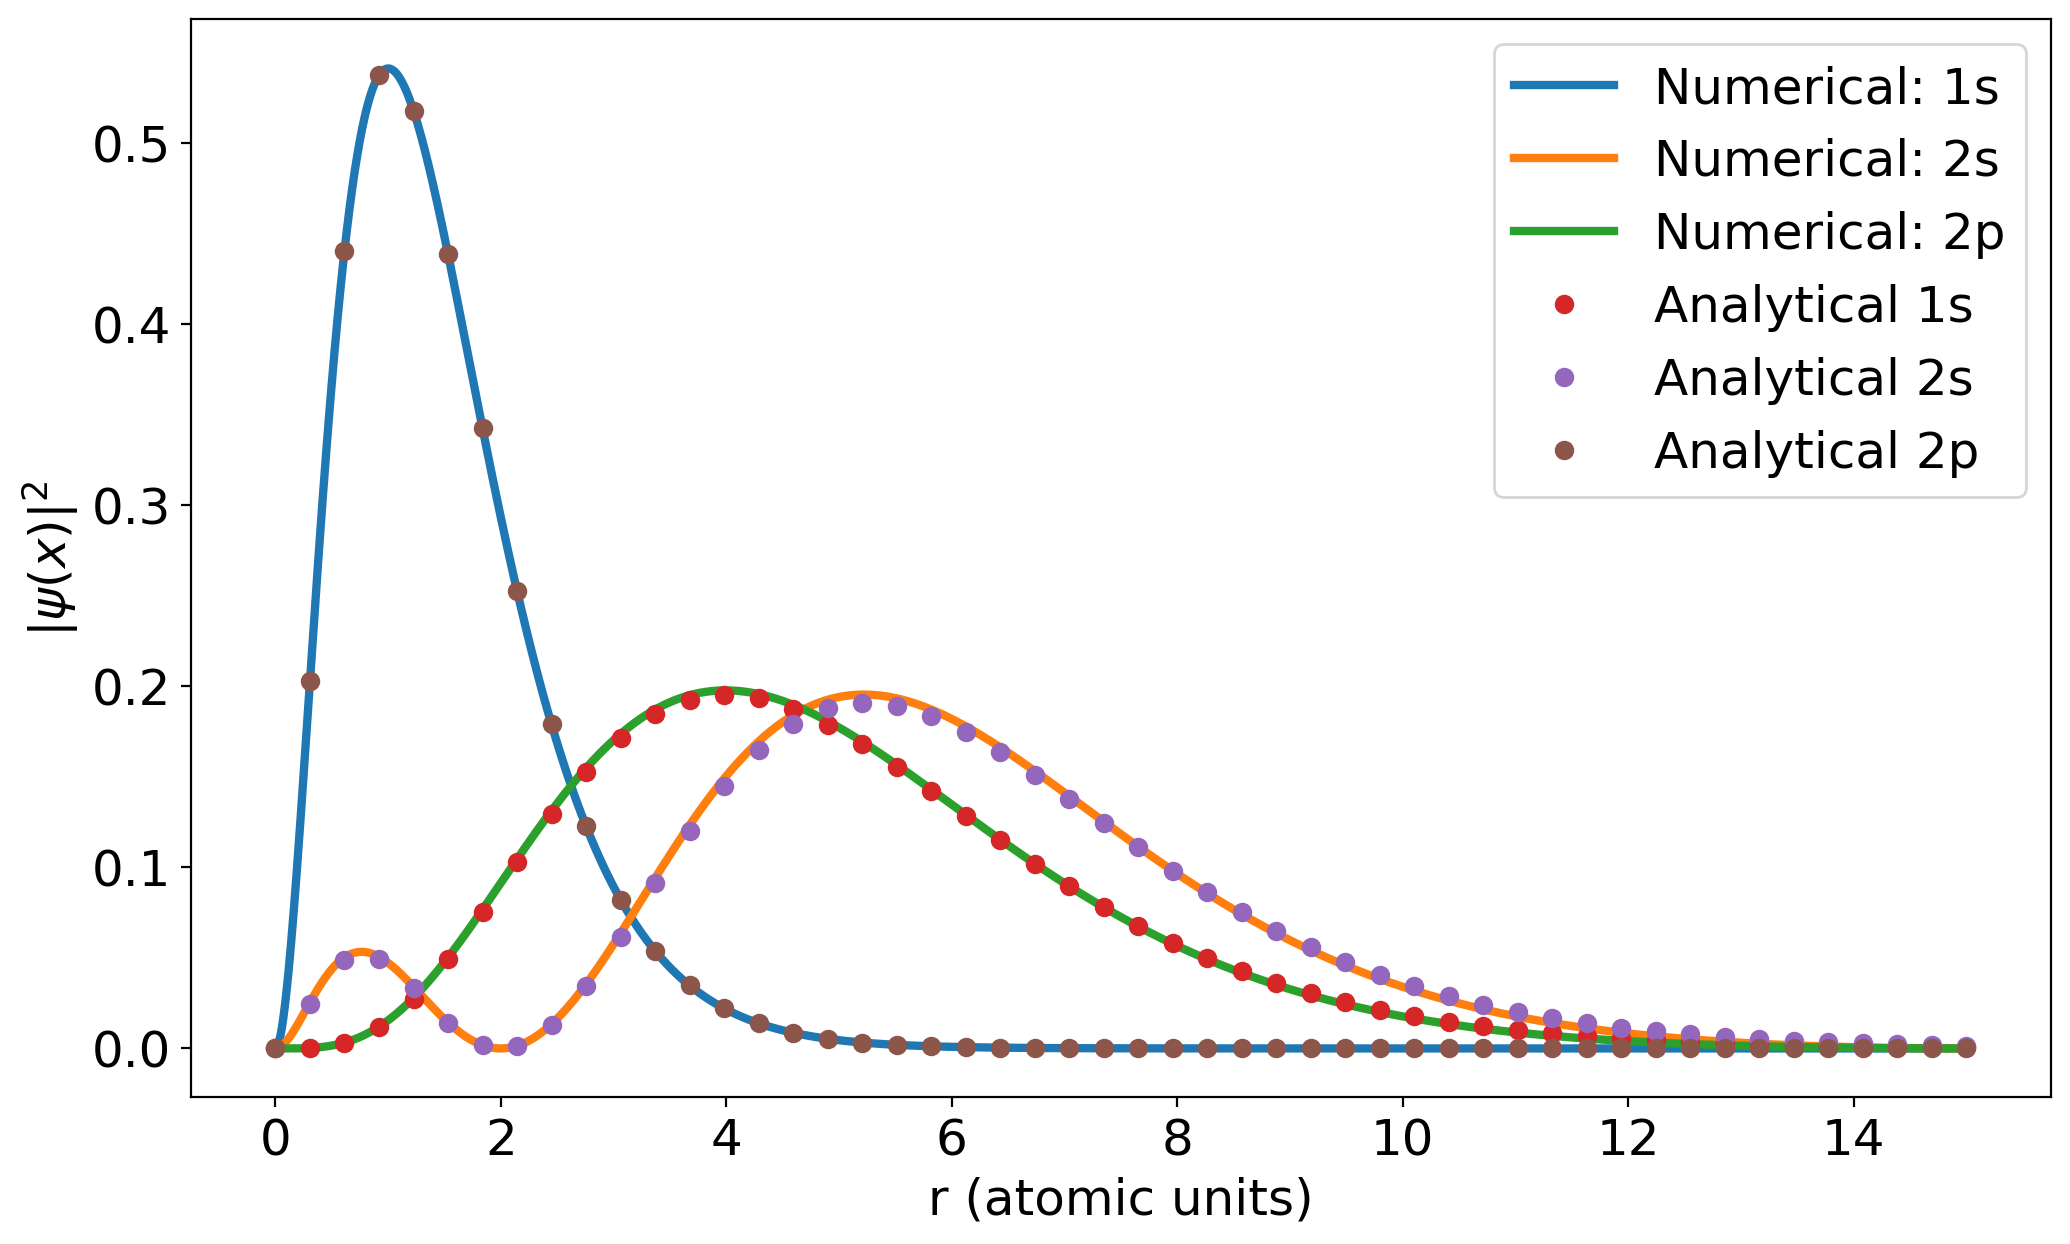

The corresponding energies of these states are:
E_1s = -2.17e-18 J = -13.55 eV
E_2s = -5.40e-19 J = -3.37 eV
E_2p = -5.41e-19 J = -3.38 eV


In [8]:
bohrRadius = 1 # eps0 = hbar = e = m = 1
upperR = 15*bohrRadius

energyConvRadial = (mass_elec*e_conv**4)/(4*np.pi*eps0_conv*hbar_conv)**2

coulombPotential = p.CoulombPotential()
r = np.linspace(0, upperR, 5000)

r_interior = r[1:]
# Construct the Hamiltonian only for r_interior
N_interior = len(r_interior)

l0 = H.RadialHamiltonian(coulombPotential, r_interior, l=0)
l1 = H.RadialHamiltonian(coulombPotential, r_interior, l=1)

eigenvalues_l0, eigenvectors_l0 = l0.solve()
eigenvalues_l1, eigenvectors_l1 = l1.solve()

# s-states (l=0)
u_1s = eigenvectors_l0[:, 0]
E_1s = eigenvalues_l0[0]
u_2s = eigenvectors_l0[:, 1]
E_2s = eigenvalues_l0[1]

# p-states (l=1)
u_2p = eigenvectors_l1[:, 0]
E_2p = eigenvalues_l1[0]

radial_states = {
    (1, 's'): u_1s/ r[1:],
    (2, 's'): u_2s/ r[1:],
    (2, 'p'): u_2p/ r[1:]
}
                                          
radial_energies = {
    (1, 's'): E_1s * energyConvRadial,
    (2, 's'): E_2s * energyConvRadial,
    (2, 'p'): E_2p * energyConvRadial
}

for state in radial_states.keys():
    n, l = state
    eigenfunc = radial_states[state]
    probDens = r[1:]**2 * np.abs(eigenfunc)**2
    probDens /= simps(r[1:]**2 * np.abs(eigenfunc)**2, r[1:])
    plt.plot(r[1:], probDens, label=f'Numerical: {n}{l}', lw=3)

# Plotting the accepted values
r_plotting = np.linspace(0, upperR, 50)
radius = symbols('r')
n, l = 2, 1  # Example quantum numbers
n_2, l_2 =  1, 0
n_3, l_3 =  2, 0
R = R_nl(n, l, radius)
R_2 = R_nl(n_2, l_2, radius)
R_3 = R_nl(n_3, l_3, radius)

R_func = lambdify(radius, R, modules=['numpy'])
R_func_2 = lambdify(radius, R_2, modules=['numpy'])
R_func_3 = lambdify(radius, R_3, modules=['numpy'])

R_vals = R_func(r_plotting)
R_vals_2 = R_func_2(r_plotting)
R_vals_3 = R_func_3(r_plotting)
    
plt.plot(r_plotting, (r_plotting**2 * np.abs(R_vals)**2), label = 'Analytical 1s', linestyle = '', marker = 'o', markersize=6)
plt.plot(r_plotting, (r_plotting**2 * np.abs(R_vals_3)**2), label = 'Analytical 2s', linestyle = '', marker = 'o', markersize=6)
plt.plot(r_plotting, (r_plotting**2 * np.abs(R_vals_2)**2), label = 'Analytical 2p', linestyle = '', marker = 'o', markersize=6)


    
plt.legend(fontsize=18)
plt.xlabel("r (atomic units)", fontsize=18)
plt.ylabel(r"$|\psi(x)|^2$", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

print(f"The corresponding energies of these states are:")
for state in radial_states.keys():
    n, l = state
    print(f"E_{n}{l} = {radial_energies[state]:.2e} J = {radial_energies[state]/e_conv:.2f} eV")

    
#r_numerical = np.linspace(0.00001, 20 * bohrRadius, N)
#plt.plot(r_interior, R_nl(1, 0, r_interior, 1))    


In [9]:
np.abs((radial_energies[(1, 's')] - E_nl(1)*energyConvRadial)/  (E_nl(1)*energyConvRadial)) * 100

0.000225105374873448

In [18]:
print(f'n=2 : {E_nl(1)*energyConvRadial/e_conv:.1f} eV')
print(f'n=2 : {E_nl(2)*energyConvRadial/e_conv:.2f} eV')

n=2 : -13.5 eV
n=2 : -3.39 eV


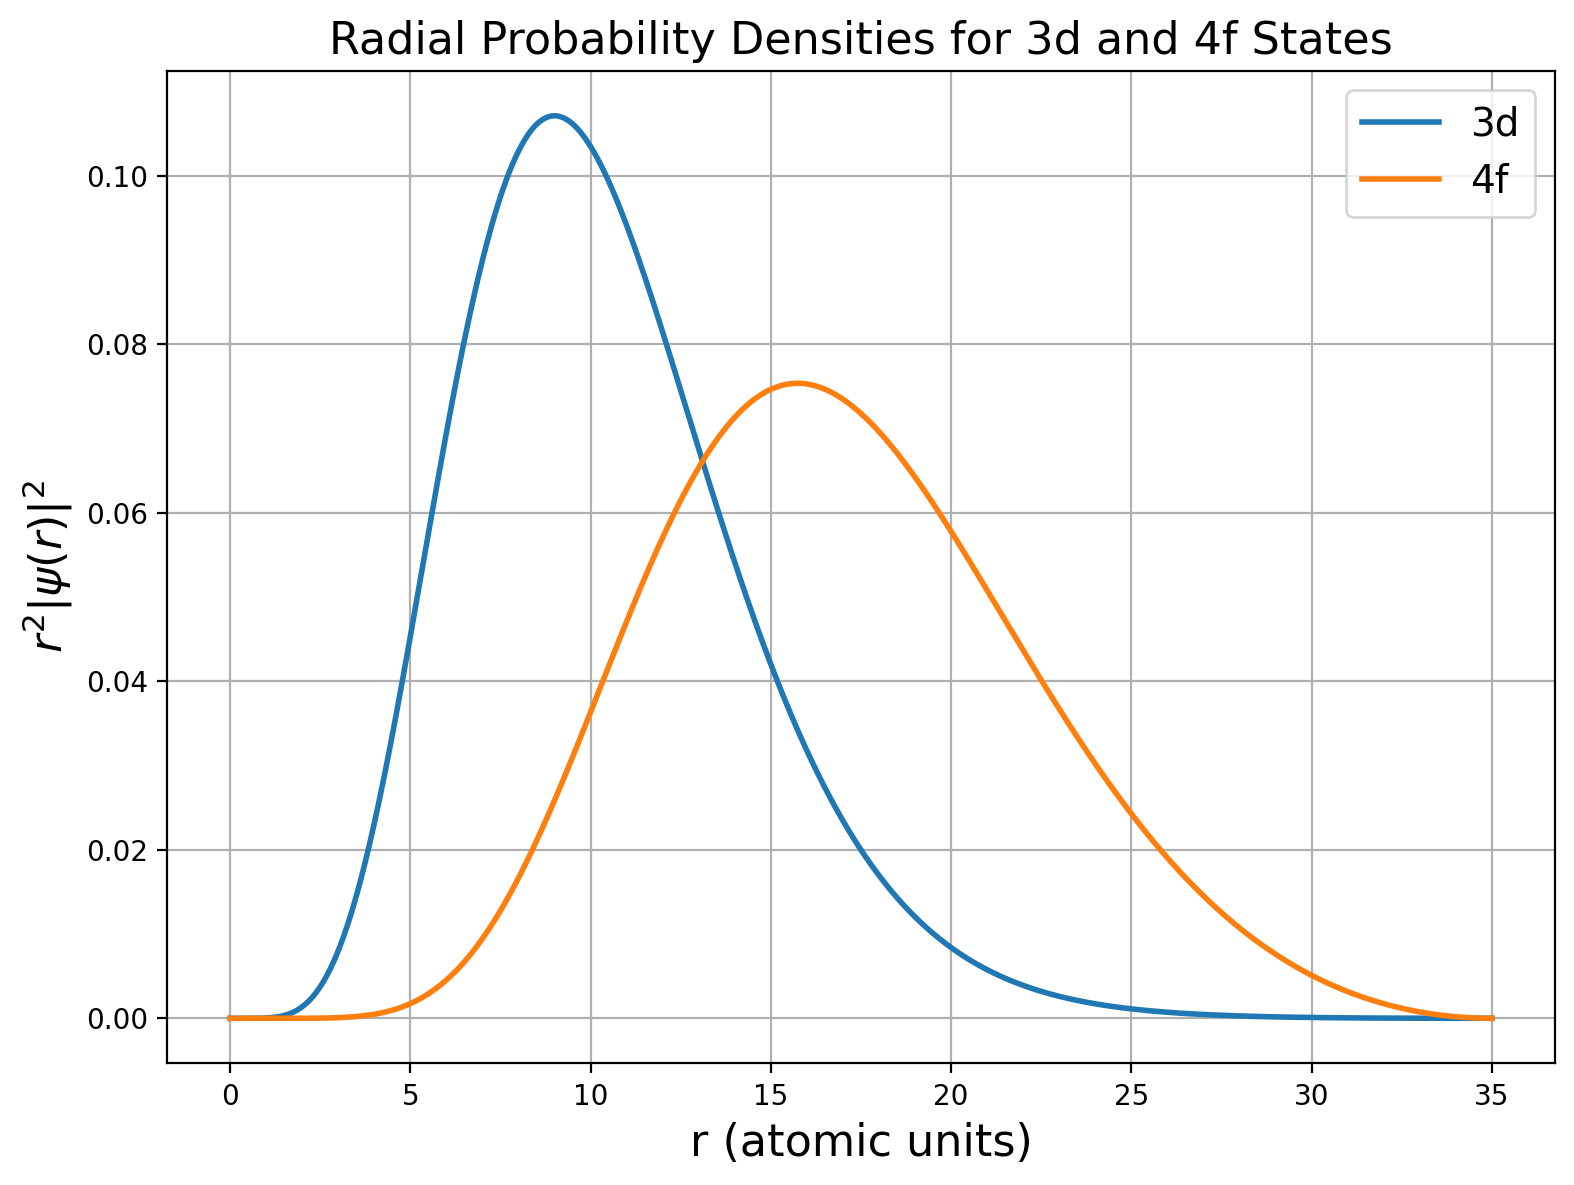

In [8]:

# Constants (in atomic units)
bohrRadius = 1
upperR = 35 * bohrRadius
r = np.linspace(0, upperR, 5000)
r_interior = r[1:]  # exclude r = 0
N_interior = len(r_interior)

# Hamiltonians for l=2 (d) and l=3 (f)
coulombPotential = p.CoulombPotential()
l_d = 2
l_f = 3

H_d = H.RadialHamiltonian(coulombPotential, r_interior, l=l_d)
H_f = H.RadialHamiltonian(coulombPotential, r_interior, l=l_f)

eigenvalues_d, eigenvectors_d = H_d.solve()
eigenvalues_f, eigenvectors_f = H_f.solve()

# Get the correct eigenvector index for n=3, l=2 → index = n - l - 1 = 0
u_3d = eigenvectors_d[:, 0]  # first eigenstate for l=2

# For n=4, l=3 → index = 0 again
u_4f = eigenvectors_f[:, 0]  # first eigenstate for l=3

# Convert radial wavefunctions u(r) to ψ(r) = u(r)/r
radial_states = {
    (3, 'd'): u_3d / r_interior,
    (4, 'f'): u_4f / r_interior,
}

# Plot probability densities
plt.figure(figsize=(8, 6))
for (n, l), psi_r in radial_states.items():
    prob_density = r_interior**2 * np.abs(psi_r)**2
    prob_density /= simps(prob_density, r_interior)  # normalise
    plt.plot(r_interior, prob_density, label=f'{n}{l}', lw=2)

plt.xlabel("r (atomic units)", fontsize=16)
plt.ylabel(r"$r^2 |\psi(r)|^2$", fontsize=16)
plt.title("Radial Probability Densities for 3d and 4f States", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()